In [90]:
import os
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Part I
## Dickey-Fuller Test

**Basic info** <br>
 <br>
After printing the info of the dataframe, we can know the dimension is [3645 rows x 56 columns], which tells us there are 3645 trades, spanning from 2000-01-03 to 2014-06-30.

In [91]:
# Read in the excel as a dataframe
data = pd.read_excel("Assignment_PAIRS_data.xlsx", sheet_name='data', header=6)

### Calculate Returns
Now we are going to calculate the **returns** for both White and Black.

In [92]:
def calculate_returns(df, strat, period):
    ret = (df[f"close{strat}"] - df[f"close{strat}"].shift(period)) / df[f"close{strat}"].shift(period)
    return ret

data["ret1WHITE"] = calculate_returns(data, "WHITE", 1)
data["WHITE_ret5"] = calculate_returns(data, "WHITE", 5)
data["WHITE_ret10"] = calculate_returns(data, "WHITE", 10)
data["WHITE_ret20"] = calculate_returns(data, "WHITE", 20)

data["ret1BLACK"] = calculate_returns(data, "BLACK", 1)
data["BLACK_ret5"] = calculate_returns(data, "BLACK", 5)
data["BLACK_ret10"] = calculate_returns(data, "BLACK", 10)
data["BLACK_ret20"] = calculate_returns(data, "BLACK", 20)

print(data["WHITE_ret10"])

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3640   -0.004185
3641    0.009114
3642    0.015937
3643    0.018007
3644    0.020445
Name: WHITE_ret10, Length: 3645, dtype: float64


### Stationarity Check

In [93]:
import statsmodels.api as sm

In [94]:
# Convert the date column to a datetime object
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

**Calculate the diff series and deltas**

In [98]:
# The diffs
dates = pd.date_range(start='2000-01-03', periods=1000)
white = pd.Series(data["closeWHITE"][:1000].values, index=dates)
black = pd.Series(data["closeBLACK"][:1000].values, index=dates)
regression_data = pd.DataFrame({'white':white, 'black':black})
regression_data['diff_series'] = regression_data['white'] - regression_data['black']

# The deltas
regression_data['deltas'] = regression_data['diff_series'].diff()
regression_data['diff_series_lagged'] = regression_data['diff_series'].shift(1)
regression_data = regression_data.dropna()

X = regression_data['diff_series_lagged']
y = regression_data['deltas']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 deltas   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     7.209
Date:                Mon, 01 Apr 2024   Prob (F-statistic):            0.00738
Time:                        12:44:54   Log-Likelihood:                -494.54
No. Observations:                 999   AIC:                             993.1
Df Residuals:                     997   BIC:                             1003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1453      0

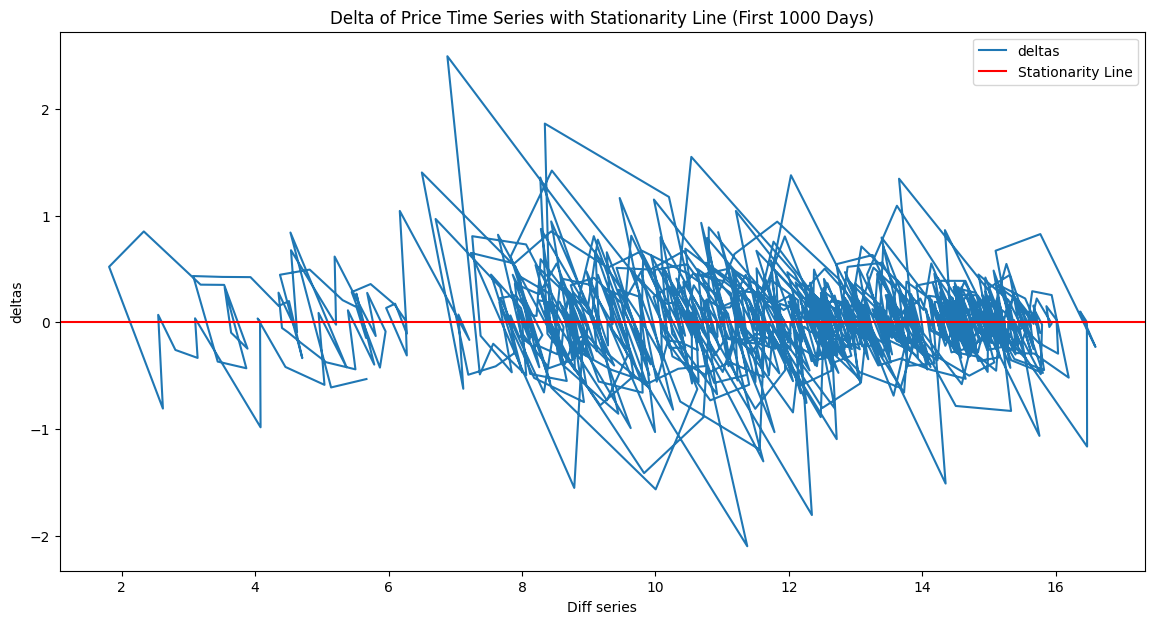

In [99]:
plt.figure(figsize=(14, 7))

plt.plot(regression_data['diff_series_lagged'], regression_data['deltas'], label='deltas')

# Adding a horizontal stationarity line at y=0
plt.axhline(y=0, color='r', linestyle='-', label='Stationarity Line')

plt.title('Delta of Price Time Series with Stationarity Line (First 1000 Days)')
plt.xlabel('Diff series')
plt.ylabel('deltas')
plt.legend()

plt.show()


### Conclusion
The regression analysis indicates a stationarity in the difference series between two trading strategies, as evidenced by the negative coefficient for the lagged differences, suggesting that the series tends to revert to a mean level over time. 

However, the model's low R-squared value signals that additional factors may influence the series. While these findings hint at stationarity, the stationarity is not very strong, which does NOT make it a promissing pair based on the stationarity test.

# Part II
## Spread Trading Strategy
Independent of the result you get in part 1 above, use the two instruments’ data on the class website to build a pairs trading strategy that relies on their “spread” to be mean reverting. In our case we calculate three spreads based on lookback windows of 5, 10, and 20 days. The spread will be a difference of trailing N-day normalized returns between the two instruments. Do this as follows:

### Calculate volatility

In [100]:
daily_returns_white = data["closeWHITE"].pct_change().dropna()
data["vol20WHITE"] = daily_returns_white.rolling(window=20).std()

daily_returns_black = data["closeBLACK"].pct_change().dropna()
data["vol20BLACK"] = daily_returns_white.rolling(window=20).std()
data["vol20BLACK"]

Date
2000-01-03         NaN
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
                ...   
2014-06-24    0.007417
2014-06-25    0.007409
2014-06-26    0.007260
2014-06-27    0.007128
2014-06-30    0.007105
Name: vol20BLACK, Length: 3645, dtype: float64

### II.a Calculate Z-scores
Compute the normalized N-day returns (z-scores) as usual for the two instruments (where you choose N to be say, 5, 10, and 20 days) for each stock based on 60 trailing values.

In [108]:
def calculate_z(df, strat, period):
    # df['last_value'] = df['your_column_name'].shift(1)
    N_day_return = df[f"close{strat}"].pct_change(period)
    rolling_mean = N_day_return.rolling(window=60).mean()
    rolling_std = N_day_return.rolling(window=60).std()
    z_score = (N_day_return - rolling_mean) / rolling_std
    return z_score

periods = [5,10,20]
for i in periods:
    data[f"zWHITE{i}"] = calculate_z(data, "WHITE", i)
    data[f"zBLACK{i}"] = calculate_z(data, "BLACK", i)

print(data["zBLACK10"])

Date
2000-01-03         NaN
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
                ...   
2014-06-24    0.656631
2014-06-25    1.002072
2014-06-26    1.200235
2014-06-27    1.388698
2014-06-30    1.199424
Name: zBLACK10, Length: 3645, dtype: float64


### II.b. Calculate zdiff
Compute the differences of the calculated normalized returns (i.e., zdiff5 = zret5_White minus zret5_Black). These will be used to specify the entry and exit levels for each trade. (As stated above, use the trailing 60 values for normalizing returns, that is, for calculating zPEP5, zPEP10, etc., and then calculate the differences of the normalized returns between White and Black, which are designated as zdiff5, zdiff10, and zdiff20.

In [124]:
data["zdiff5"] = data["zWHITE5"] - data["zBLACK5"]
data["zdiff10"] = data["zWHITE10"] - data["zBLACK10"]
data["zdiff20"] = data["zWHITE20"] - data["zBLACK20"]

### II.c. Calculate the sigma for the systems
Apply the following decision rule: If zdiff5 (do the same for zdiff10 and zdiff20), exceeds some positive threshold, you “short the spread,” that is, short the outperformer and go long the underperformer with the expectation that the spread will revert. Similarly, if the spread is below some negative threshold, do the opposite, namely, go long the spread. Use the spreadsheet template provided to do the assignment.

In [130]:
sigma_zdiff5 = data['zdiff5'].std()
sigma_zdiff10 = data['zdiff10'].std()
sigma_zdiff20 = data['zdiff20'].std()

**Calculating Signals**

In [163]:
for N in [5, 10, 20]:
    sigma_zdiff = sigma_zdiff5 if N == 5 else sigma_zdiff10 if N == 10 else sigma_zdiff20
    # Short signals
    data[f'signal{N}'] = np.where(data[f'zdiff{N}'] > sigma_zdiff, -1, 0)
    data[f'Scap{N}?'] = np.where(data[f'zdiff{N}'] > sigma_zdiff, 1, -1) # 1 means yes, -1 means no
    
    # long signals
    data[f'signal{N}'] = np.where(data[f'zdiff{N}'] < -sigma_zdiff, 1, data[f'signal{N}'])
    data[f'Lcap{N}?'] = np.where(data[f'zdiff{N}'] > sigma_zdiff, 1, -1) # 1 means yes, -1 means no

**Calculate the FRet**

In [162]:
# Calculate forward returns (shift(-1) to get next day's return)
data['forwardReturnWhite'] = data['ret1WHITE'].shift(-1)
data['forwardReturnBlack'] = data['ret1BLACK'].shift(-1)
# Adjust forward returns by volatility and calculate FRet1
data['FRet1'] = (data['forwardReturnWhite'] / data['vol20WHITE']) - (data['forwardReturnBlack'] / data['vol20BLACK'])
data['FRet1'].tail()

# Calculate the FRet1_z5,10, 20 
for N in [5, 10, 20]:
    data[f'fret1_z{N}'] = (data[f'WHITE_ret{N}'] / data[f'vol20WHITE']) - (data[f'BLACK_ret{N}'] / data[f'vol20BLACK'])

Date
2014-06-24   -0.004185
2014-06-25    0.009114
2014-06-26    0.015937
2014-06-27    0.018007
2014-06-30    0.020445
Name: WHITE_ret10, dtype: float64